### Notebook to be used to perform manual focus testing using ACCS Images. In this case we're taking the focus at a few different wavelengths to look at the focus shift as a fxn of wavelength for an on-axis image (0th order).

In [1]:
import numpy as np
from lsst.ts import salobj
import asyncio
from astropy.io import fits
import os

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt

In [2]:
d = salobj.Domain()

ATArchiver = salobj.Remote(d, 'ATArchiver')
await ATArchiver.start_task
ATCamera = salobj.Remote(d, 'ATCamera')
await ATCamera.start_task
LinearStage = salobj.Remote(d, 'LinearStage',1)
await LinearStage.start_task
#ATMonochromator = salobj.Remote(SALPY_ATMonochromator)

In [3]:
await salobj.set_summary_state(LinearStage, salobj.State.ENABLED)

RuntimeError: Error on cmd=cmd_enable, initial_state=1

## Setup the Linear Stage (focuser)

In [ ]:
#get_home_1 = await cmd(ls_1_remote,"getHome")
pos=LinearStage1.tel_position.get()
print('Current stage position is {:0.4f} [mm]'.format(pos.position))

In [8]:
# Home the stage (only necessary if power was off)
if False:
    try:
        asyncio.get_event_loop().run_until_complete(LinearStage1.cmd_getHome.start())
    except AckError as ack_err:
        print(f"Failed with ack.result={ack_err.ack.result}")
else:
    print('Ignoring')

Ignoring


In [4]:
# Home the stage (only necessary if power was off)
lin_stage_pos=69.8
LinearStage1.cmd_moveAbsolute.set(distance=lin_stage_pos)
try:
    asyncio.get_event_loop().run_until_complete(LinearStage1.cmd_moveAbsolute.start())
except AckError as ack_err:
    print(f"Failed with ack.result={ack_err.ack.result}")

NameError: name 'LinearStage1' is not defined

#### Setup the Camera

In [7]:
wavelength = 632
#wavelength = 540
#wavelength=455
group_id='Focus'+str(wavelength)+str(lin_stage_pos)

ATCamera.cmd_takeImages.set(expTime=1, shutter=1, numImages=1, image_type='OBJECT')

AttributeError: 'ATCamera_command_takeImages_ce3476c3' object has no attribute 'image_type'

In [6]:
try:
    asyncio.get_event_loop().run_until_complete(ATCamera.cmd_takeImages.start())
except salobj.AckError as ack_err:
    print(f"Failed with ack.result={ack_err.ack.result}")

endReadout = asyncio.get_event_loop().run_until_complete(ATCamera.evt_endReadout.next(flush=True, timeout=30))
print(endReadout.imageName)

AT_O_20190606_000004


In [7]:
# Read in image
dayobs=((endReadout.imageName).split('_'))[2]
#dir = '/mnt/dmcs/20180823'
data_dir=os.path.join('/mnt/data/ats/mcm/',dayobs)
#dir = '/mnt/data/ats/mcm/20190604/'
#atcamera_fname='AT_O_20190403_000072'
atcamera_fname=endReadout.imageName

#dir = '/mnt/dmcs/2019-03-08/'
#atcamera_fname='AT_O_20190308_000125-ats-wfs_ccd'

full_file_name=os.path.join(data_dir, atcamera_fname+'.fits')
print('Opening {}'.format(full_file_name))
hdu_list = fits.open(full_file_name)
#hdu_list.info()
#amp=12 # upper amp
amp=5 # lower amp (in ds9)

amp=4 # lower amp (in ds9)
im=hdu_list[amp].data 

im0=im

bias_full_file_name='/mnt/dmcs/2019-04-05/AT_O_20190405_000053-ats-wfs_ccd.fits'
bias_hdu_list = fits.open(bias_full_file_name)
#hdu_list.info()
bias=bias_hdu_list[amp].data # for camera data

im-=bias

# seems like the top part of the image is often bad, just setting to zero
im[0:10,:]=0


Opening /mnt/data/ats/mcm/20190606/AT_O_20190606_000004.fits


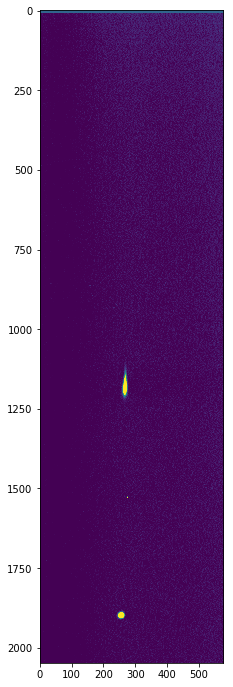

In [8]:
if True:
    plt.rcParams['figure.figsize'] = [14, 12]
    im_sub=im0 -np.median(im0)
    plt.imshow(im_sub, vmin=0, vmax=500)
    hdu_list.close()

In [9]:
# remove hot/bad pixels
from scipy.ndimage import median_filter
blurred = median_filter(im, size=3)
difference = im - blurred
threshold = 10*np.std(difference)
im_badpix_corr = np.empty_like(im)
im_badpix_corr[:] = im
#im_badpix_corr[difference>threshold] = 0

In [10]:
# Find star by convolution with gaussian, then grab the max
star_finder_img=gaussian_filter(im,[5,5],order=0, mode='constant',cval=0)

# Cut out the area with the 1st order image
half_side = 20
zero_ord_pos = [1898, 403]
ymin = zero_ord_pos[0]-half_side if zero_ord_pos[0]-half_side > 0 else 0
ymax = zero_ord_pos[0]+half_side if zero_ord_pos[0]+half_side < 2047 else 2047
xmin = zero_ord_pos[1]-half_side if zero_ord_pos[1]-half_side > 0 else 0
xmax = zero_ord_pos[1]+half_side if zero_ord_pos[1]+half_side < 512 else 512
if False:
    print('Cutting out area with zero order image')
    print('ymin,ymax,xmin,xmax = [{}, {}, {}, {}]'.format(ymin,ymax,xmin,xmax))
    star_finder_img[ymin:ymax,xmin:xmax] = -1e9 #np.nan

# If the wavelength is longer than 700nm, then there will be 2nd order contamination.
# This means that the "star" finder below will find the wrong peak if the 2nd order is brighter than the first.
if True and wavelength > 700:
    print('Removing 2nd order light from star finding image')
    #star_finder_img[800::,:]=-1e99

#print(np.max(star_finder_img))
value=None
ind=np.argmax(star_finder_img)
ind2d = np.unravel_index(ind,star_finder_img.shape)
print('centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

centroid at y,x: 1897 254


In [11]:
# Create sub-image
#ymin=1800 ; ymax=2048
#xmin=280 ; xmax=450
half_side=int(30)
ymin = ind2d[0]-half_side if ind2d[0]-half_side > 0 else 0
ymax = ind2d[0]+half_side if ind2d[0]+half_side < 2047 else 2047
xmin = ind2d[1]-half_side if ind2d[1]-half_side > 0 else 0
xmax = ind2d[1]+half_side if ind2d[1]+half_side < 512 else 512
print('subimage being made from ymin,ymax,xmin,xmax:{} {} {} {}'.format(ymin,ymax,xmin,xmax))
# new maximum at:
ind=np.argmax(star_finder_img[ymin:ymax,xmin:xmax])
ind2d = np.unravel_index(ind,star_finder_img[ymin:ymax,xmin:xmax].shape)
print('new centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

subimage being made from ymin,ymax,xmin,xmax:1867 1927 224 284
new centroid at y,x: 30 30


37885


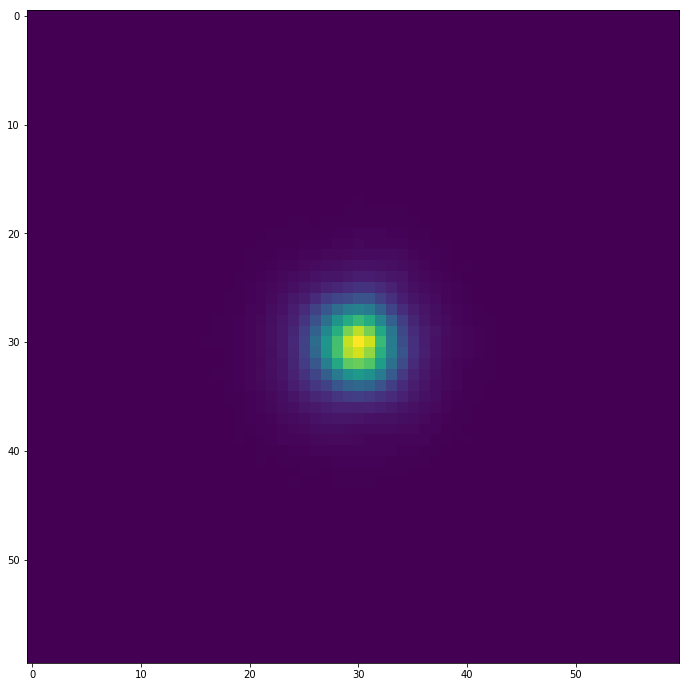

In [12]:
im_sub=im0[ymin:ymax,xmin:xmax]
#im_sub=im_sub-np.median(im_sub)
plt.imshow(im_sub)
hdu_list.close()
print(np.nanmax(im_sub))

30
30


Text(0.5,1,'Residual')

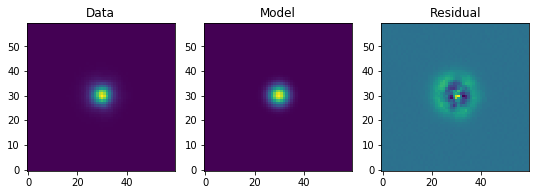

In [13]:
# Generate x,y,z data
y, x = np.mgrid[:im_sub.shape[0], :im_sub.shape[1]]
print(y[ind2d])
print(x[ind2d])
z=im_sub
# Fit the data using astropy.modeling
p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=x[ind2d], y_mean=y[ind2d], fixed={'theta':True})
#p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=38, y_mean=51, x_stddev=3, y_stddev=3,  fixed={'theta':True})
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
plt.figure(figsize=(9, 5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Residual")

In [399]:
#print(atcamera_fname)
#print(repr(p))
print(['dist', 'filename', p.param_names[0:5],'wavelength'])
print('{}, {}, {:0.3f}, {:0.3f}, {:0.3f}, {:0.3f}, {:0.3f}, {:0.2f}'.format(dist,
    atcamera_fname, p.amplitude.value, p.x_mean.value+xmin, p.y_mean.value+ymin,
    p.x_stddev.value, p.y_stddev.value, wavelength))

['dist', 'filename', ('amplitude', 'x_mean', 'y_mean', 'x_stddev', 'y_stddev'), 'wavelength']
86.85, AT_O_20190603_000052, 60885.215, 369.193, 1824.672, 2.303, 2.260, 632.00


In [348]:
#### file, focus pos [in], amplitude, x_mean, y_mean, x_stddev, y_stddev, theta [fixed] 
# no filter, 90 l/mm disperser, stage at 64.998

86.85, AT_O_20190603_000042, 42173.314, 369.326, 1819.195, 2.574, 3.034, 632.00
86.85, AT_O_20190603_000043, 89344.670, 368.816, 1822.324, 2.804, 2.637, 632.00
86.85, AT_O_20190603_000044, 82144.976, 369.410, 1823.173, 2.547, 2.990, 632.00 # after sending camera to standby
86.85, AT_O_20190603_000045, 83521.837, 369.526, 1823.285, 2.500, 3.005, 632.00 # just another image
86.85, AT_O_20190603_000046, 52695.815, 369.287, 1823.351, 2.515, 3.235, 632.00 # reduced exposure time 
86.85, AT_O_20190603_000049, 55885.885, 368.905, 1824.598, 2.257, 2.438, 632.00
86.85, AT_O_20190603_000050, 65067.855, 368.610, 1824.707, 2.124, 2.165, 632.00
86.85, AT_O_20190603_000052, 60885.215, 369.193, 1824.672, 2.303, 2.260, 632.00



NameError: name 'AT_O_20190603_000042' is not defined

In [ ]:
# magnification of the system is ~3.2, so 15um pinhole becomes 48um, which is a width of ~5 pixels
# but it'll be resolved... 5 pixel wide top hat convolved with the diffraction limit (for a perfect system)
# diffraction limit is 3.1 pixels FWHM. 
#The zemax model shows that we're not going to (easily) resolve the pinhole, so it'll basically
# be a Gaussian. Moreover, we're definitely not using a perfect optical system so there's
# aberrations that will certainly reduce our resolution. I expect to measure a Gaussian profile.

In [239]:
632e-9*400/24. * 1e6

10.533333333333335

In [346]:
632/120

5.266666666666667

In [288]:
# Make an encircled energy plot
pix_index_1d_arr=np.arange(0,2*half_side,1)
ones_array_2d=np.ones([2*half_side,2*half_side])
#print(x_arr)
#print(tmp)
x_index_arr_2d=pix_index_1d_arr*ones_array_2d
x_arr_2d=x_index_arr_2d - p.x_mean.value
y_arr_2d= np.transpose(x_index_arr_2d) - p.y_mean.value
# create array of radial distances (in pixels)
r_arr_2d=np.sqrt(x_arr_2d**2 + y_arr_2d**2)

In [289]:
if False:
    plt.imshow(r_arr_2d)
    plt.colorbar()

In [290]:
r_arr_1d=np.reshape(r_arr_2d,(2*half_side)**2)
values = np.reshape(z,(2*half_side)**2)

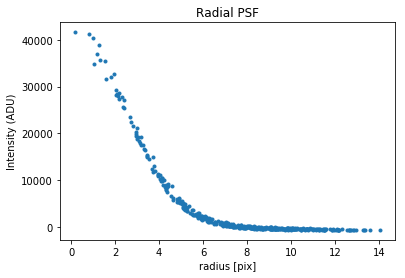

In [291]:
if True:
    plt.ylabel('Intensity (ADU)')
    plt.plot(r_arr_1d, values,'.')
    plt.title('Radial PSF')
    plt.xlabel('radius [pix]')
    plt.show()
    plt.close()